In [0]:
import pandas as pd, numpy as np
import sys, os, cv2, random, shutil,time                                                                                                                                                      
import PIL
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks import SaveModelCallback
from sklearn.model_selection import KFold,StratifiedKFold

import sklearn.metrics as skmetrics

In [0]:
from fastai_extensions import *
from efficientnet_pytorch import EfficientNet
import albumentations as A

In [0]:
RANDOM_STATE = 41
def fix_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
fix_seed(RANDOM_STATE)

In [0]:
DATA_DIR = 'data/'
df_train = pd.read_csv(f'{DATA_DIR}/Train.csv')
df_test = pd.read_csv(f'{DATA_DIR}/Test.csv')
MODEL_DIR = '../../models' #save models to current directory

In [0]:
df_train['path']  = df_train['ID']+'.jpg'
df_train['Label']  = df_train['Label'].astype(np.int8)

In [0]:
n_splits=5
df_oof = df_train.copy()
y_valid_preds=[]; y_test_preds = []
kfold = StratifiedKFold(n_splits=n_splits, random_state=RANDOM_STATE, shuffle=True)
IXS_TRAIN = []; IXS_VAL = []

for i, (ix_train, ix_val) in enumerate(kfold.split(X=df_train, y=df_train.Label)):
  fix_seed(RANDOM_STATE)
  IXS_TRAIN.append(ix_train)
  IXS_VAL.append(ix_val)
  

In [0]:
path = Path('data/train')
size = 200
bs = 16
tfms = get_transforms()

In [0]:
pos = np.sum(df_train.Label)
neg = df_train.shape[0] - pos
weights = torch.FloatTensor([1, neg / pos])
weights = weights.to(device)
weights

tensor([1.0000, 2.9132], device='cuda:0')

In [0]:
def get_learner(fold_id):
  ix_train = IXS_TRAIN[fold_id]
  ix_val = IXS_VAL[fold_id]
  train = df_train.iloc[ix_train]
  val = df_train.iloc[ix_val]
  data = (ImageList.from_df(path=path,df=df_train[['path','Label']])
        .split_by_idxs(ix_train, ix_val)
        .label_from_df()
        .transform(tfms,size=size,padding_mode='reflection')
        .databunch(bs=bs, num_workers=4)
        .normalize(imagenet_stats))
  model = EfficientNet.from_pretrained('efficientnet-b5',num_classes=2) 
  learn = Learner(data, model,
                    loss_func=nn.CrossEntropyLoss(weight=weights),
                    metrics=[accuracy],
                    callback_fns=[BnFreeze]
                  ).cutmix()
  learn.split( lambda m: (model._conv_head,) )
  learn.model_dir = MODEL_DIR
  learn.freeze()
  return learn

In [0]:
fix_seed(RANDOM_STATE)
fold_id = 0
model_name = 'effnet5_cmix_F'+str(fold_id)
learn = get_learner(fold_id)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/checkpoints/efficientnet-b5-b6417697.pth



Loaded pretrained weights for efficientnet-b5


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-05
Min loss divided by 10: 8.32E-04


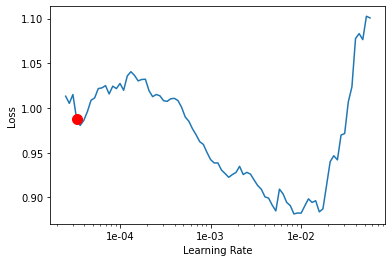

In [0]:
# train head
fix_seed(RANDOM_STATE)
learn.lr_find(start_lr=1e-5, end_lr=1e-1, wd=5e-3)
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.647629,0.366708,0.898483,02:25
1,0.765183,0.460489,0.875146,02:25
2,0.816106,1.218869,0.592765,02:25
3,0.650634,0.213030,0.953326,02:25
4,0.616009,0.310121,0.936989,02:25
5,0.539688,0.190263,0.945158,02:25
6,0.515071,0.219723,0.934656,02:25
7,0.535469,0.182858,0.942824,02:25
8,0.512823,0.188526,0.948658,02:25
9,0.453406,0.182768,0.950992,02:25


Better model found at epoch 0 with valid_loss value: 0.3667076528072357.
Better model found at epoch 3 with valid_loss value: 0.21302993595600128.
Better model found at epoch 5 with valid_loss value: 0.19026264548301697.
Better model found at epoch 7 with valid_loss value: 0.18285848200321198.
Better model found at epoch 9 with valid_loss value: 0.1827678382396698.


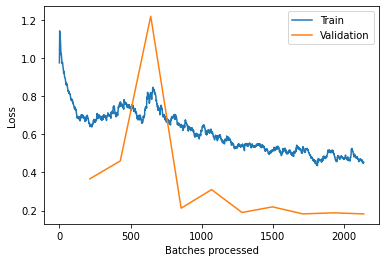

In [0]:
learn.fit_one_cycle(10, max_lr=8e-3, wd=5e-3, moms=(0.9, 0.8),callbacks=[SaveModelCallback(learn, monitor='valid_loss', mode='min', name=model_name+'P0')])
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 1.58E-07


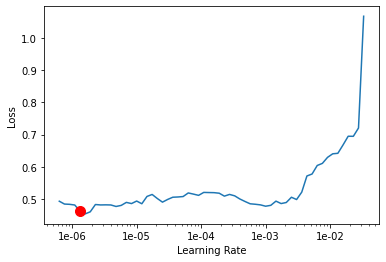

In [0]:
# unfreeze
fix_seed(RANDOM_STATE)
learn.load(model_name+'P0')
learn.unfreeze()
learn.lr_find(wd=1e-3)
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.471195,0.180131,0.943991,03:22
1,0.435432,0.170192,0.954492,03:22
2,0.476805,0.167544,0.945158,03:22
3,0.461713,0.169121,0.946324,03:23
4,0.450820,0.155692,0.957993,03:23
5,0.470971,0.194589,0.970828,03:23
6,0.472507,0.157105,0.957993,03:23
7,0.424441,0.152867,0.966161,03:23
8,0.406012,0.153136,0.964994,03:23
9,0.428408,0.130524,0.955659,03:22


Better model found at epoch 0 with valid_loss value: 0.1801307499408722.
Better model found at epoch 1 with valid_loss value: 0.17019227147102356.
Better model found at epoch 2 with valid_loss value: 0.1675443947315216.
Better model found at epoch 4 with valid_loss value: 0.15569213032722473.
Better model found at epoch 7 with valid_loss value: 0.1528671532869339.
Better model found at epoch 9 with valid_loss value: 0.13052433729171753.
Better model found at epoch 17 with valid_loss value: 0.1295405924320221.
Better model found at epoch 20 with valid_loss value: 0.1276310682296753.
Better model found at epoch 23 with valid_loss value: 0.1248568519949913.


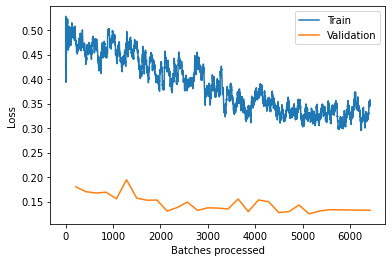

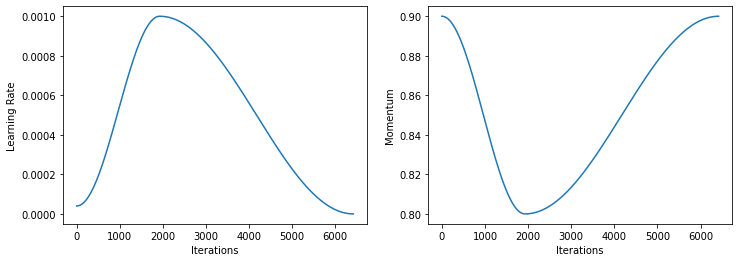

In [0]:
# train all layers 
fix_seed(RANDOM_STATE)
learn.load(model_name+'P0')
learn.fit_one_cycle(30, max_lr=slice(1e-4, 1e-3),wd=1e-3, moms=(0.9, 0.8),callbacks=[SaveModelCallback(learn, monitor='valid_loss', mode='min', name=model_name+'P1')])
learn.recorder.plot_losses()
learn.recorder.plot_lr(show_moms=True)